In [43]:
import numpy as np
from PIL import Image
import os

def rgb_to_cmy(rgb_image):
    # CMY = 1 - RGB
    cmy_image = 1.0 - rgb_image
    return cmy_image

def extract_color_features(image):
    features = []
    
    # RGB features (6)
    for channel in range(3):  # R, G, B
        channel_data = image[:, :, channel]
        features.append(np.mean(channel_data))  # Mean
        features.append(np.std(channel_data))   # Standard deviation
    
    # CMY features (6)
    cmy_image = rgb_to_cmy(image)
    for channel in range(3):  # C, M, Y
        channel_data = cmy_image[:, :, channel]
        features.append(np.mean(channel_data))  # Mean
        features.append(np.std(channel_data))   # Standard deviation
    
    return np.array(features)

def load_and_extract_features(image_dir, labels_df):
    features_list = []
    valid_indices = []
    
    for idx, row in labels_df.iterrows():
        img_path = os.path.join(image_dir, f"{row['id']}.jpg")
        
        if os.path.exists(img_path):
            img = Image.open(img_path)
            img_resized = img.resize((410, 205))
            img_array = np.array(img_resized).astype('float32') / 255.0
            
            features = extract_color_features(img_array)
            features_list.append(features)
            valid_indices.append(idx)
        else:
            print(f"Warning: {img_path} not found")
    
    features_array = np.array(features_list)
    labels = labels_df.loc[valid_indices].reset_index(drop=True)
    
    return features_array, labels

In [87]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.preprocessing import LabelEncoder

train_label_df = pd.read_csv('dataset/train_classes.csv')
test_label_df = pd.read_csv('dataset/test_classes.csv')
train_label_df['nodisease'] = 1 - (train_label_df[['miner', 'rust', 'phoma']].sum(axis=1) > 0).astype(int)
test_label_df['nodisease'] = 1 - (test_label_df[['miner', 'rust', 'phoma']].sum(axis=1) > 0).astype(int)
train_label_df.loc[train_label_df['miner'] == 1, 'rust'] = 0
test_label_df.loc[test_label_df['miner'] == 1, 'rust'] = 0

train_features, train_labels = load_and_extract_features('dataset/coffee-leaf-diseases/train/images', train_label_df)
X_test, test_labels = load_and_extract_features('dataset/coffee-leaf-diseases/test/images', test_label_df)

train_labels['class'] = train_labels[['nodisease', 'miner','rust','phoma']].idxmax(axis=1)
test_labels['class'] = test_labels[['nodisease', 'miner','rust','phoma']].idxmax(axis=1)

y_test = test_labels['class']

X_train, X_valid, y_train, y_valid = train_test_split(
    train_features, 
    train_labels['class'],
    test_size=0.2,
    stratify=train_labels['class'],
    random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

### Predict X_valid

In [90]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

labels = ['nodisease', 'miner', 'rust', 'phoma']

# ---------- Decision Tree ----------
dt = DecisionTreeClassifier(
    criterion='gini',
    max_depth=None,
    max_features=None,
    min_samples_leaf=1,
    min_samples_split=2,
    random_state=123,
    splitter='best'
)
# multi_dt = MultiOutputClassifier(dt)
# multi_dt.fit(X_train_scaled, y_train)
# y_pred_dt = multi_dt.predict(X_test_scaled)
dt.fit(X_train_scaled, y_train)
y_pred_valid_dt = dt.predict(X_valid_scaled)

print("\n=== Decision Tree Overall Metrics ===")
print(classification_report(y_valid, y_pred_valid_dt))
print("Accuracy (subset accuracy):", accuracy_score(y_valid, y_pred_valid_dt))
print("Precision (micro):", precision_score(y_valid, y_pred_valid_dt, average='micro', zero_division=0))
print("Recall (micro):", recall_score(y_valid, y_pred_valid_dt, average='micro', zero_division=0))
print("F1-score (micro):", f1_score(y_valid, y_pred_valid_dt, average='micro', zero_division=0))
print("Precision (macro):", precision_score(y_valid, y_pred_valid_dt, average='macro', zero_division=0))
print("Recall (macro):", recall_score(y_valid, y_pred_valid_dt, average='macro', zero_division=0))
print("F1-score (macro):", f1_score(y_valid, y_pred_valid_dt, average='macro', zero_division=0))

# ---------- KNN ----------
knn = KNeighborsClassifier(
    algorithm='auto',
    leaf_size=30,
    metric='minkowski',
    n_jobs=-1,
    n_neighbors=5,
    p=2,
    weights='uniform'
)
# multi_knn = MultiOutputClassifier(knn)
# multi_knn.fit(X_train_scaled, y_train)
# y_pred_knn = multi_knn.predict(X_test_scaled)
knn.fit(X_train_scaled, y_train)
y_pred_valid_knn = knn.predict(X_valid_scaled)

print("\n=== KNN Overall Metrics ===")
print("Accuracy (subset accuracy):", accuracy_score(y_valid, y_pred_valid_knn))
print("Precision (micro):", precision_score(y_valid, y_pred_valid_knn, average='micro', zero_division=0))
print("Recall (micro):", recall_score(y_valid, y_pred_valid_knn, average='micro', zero_division=0))
print("F1-score (micro):", f1_score(y_valid, y_pred_valid_knn, average='micro', zero_division=0))
print("Precision (macro):", precision_score(y_valid, y_pred_valid_knn, average='macro', zero_division=0))
print("Recall (macro):", recall_score(y_valid, y_pred_valid_knn, average='macro', zero_division=0))
print("F1-score (macro):", f1_score(y_valid, y_pred_valid_knn, average='macro', zero_division=0))


=== Decision Tree Overall Metrics ===
              precision    recall  f1-score   support

       miner       1.00      0.94      0.97        66
   nodisease       0.93      1.00      0.97        57
       phoma       1.00      1.00      1.00        78
        rust       1.00      1.00      1.00        52

    accuracy                           0.98       253
   macro avg       0.98      0.98      0.98       253
weighted avg       0.99      0.98      0.98       253

Accuracy (subset accuracy): 0.9841897233201581
Precision (micro): 0.9841897233201581
Recall (micro): 0.9841897233201581
F1-score (micro): 0.9841897233201581
Precision (macro): 0.9836065573770492
Recall (macro): 0.9848484848484849
F1-score (macro): 0.9837129237288136

=== KNN Overall Metrics ===
Accuracy (subset accuracy): 0.8300395256916996
Precision (micro): 0.8300395256916996
Recall (micro): 0.8300395256916996
F1-score (micro): 0.8300395256916996
Precision (macro): 0.8245880827843917
Recall (macro): 0.8191939639308061


#### Confusion Matrix Heatmap

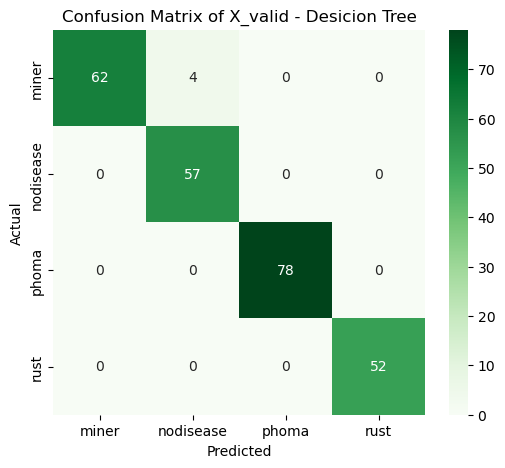

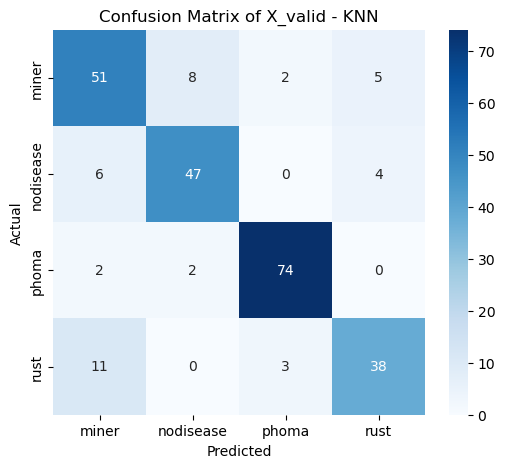

In [98]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

labels = sorted(y_test.unique())

# Desicion Tree
cm_valid_dt = confusion_matrix(y_valid, y_pred_valid_dt)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_valid_dt,
    annot=True,
    fmt='d',
    cmap='Greens',
    xticklabels=labels,
    yticklabels=labels
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of X_valid - Desicion Tree')
plt.show()

# KNN
cm_valid_knn = confusion_matrix(y_valid, y_pred_valid_knn)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_valid_knn,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=labels,
    yticklabels=labels
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of X_valid - KNN')
plt.show()

### Predict X_test

In [89]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

labels = ['nodisease', 'miner', 'rust', 'phoma']

# ---------- Decision Tree ----------
dt = DecisionTreeClassifier(
    criterion='gini',
    max_depth=None,
    max_features=None,
    min_samples_leaf=1,
    min_samples_split=2,
    random_state=123,
    splitter='best'
)
# multi_dt = MultiOutputClassifier(dt)
# multi_dt.fit(X_train_scaled, y_train)
# y_pred_dt = multi_dt.predict(X_test_scaled)
dt.fit(X_train_scaled, y_train)
y_pred_dt = dt.predict(X_test_scaled)

print("\n=== Decision Tree Overall Metrics ===")
print(classification_report(y_test, y_pred_dt))
print("Accuracy (subset accuracy):", accuracy_score(y_test, y_pred_dt))
print("Precision (micro):", precision_score(y_test, y_pred_dt, average='micro', zero_division=0))
print("Recall (micro):", recall_score(y_test, y_pred_dt, average='micro', zero_division=0))
print("F1-score (micro):", f1_score(y_test, y_pred_dt, average='micro', zero_division=0))
print("Precision (macro):", precision_score(y_test, y_pred_dt, average='macro', zero_division=0))
print("Recall (macro):", recall_score(y_test, y_pred_dt, average='macro', zero_division=0))
print("F1-score (macro):", f1_score(y_test, y_pred_dt, average='macro', zero_division=0))

# ---------- KNN ----------
knn = KNeighborsClassifier(
    algorithm='auto',
    leaf_size=30,
    metric='minkowski',
    n_jobs=-1,
    n_neighbors=5,
    p=2,
    weights='uniform'
)
# multi_knn = MultiOutputClassifier(knn)
# multi_knn.fit(X_train_scaled, y_train)
# y_pred_knn = multi_knn.predict(X_test_scaled)
knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_test_scaled)

print("\n=== KNN Overall Metrics ===")
print("Accuracy (subset accuracy):", accuracy_score(y_test, y_pred_knn))
print("Precision (micro):", precision_score(y_test, y_pred_knn, average='micro', zero_division=0))
print("Recall (micro):", recall_score(y_test, y_pred_knn, average='micro', zero_division=0))
print("F1-score (micro):", f1_score(y_test, y_pred_knn, average='micro', zero_division=0))
print("Precision (macro):", precision_score(y_test, y_pred_knn, average='macro', zero_division=0))
print("Recall (macro):", recall_score(y_test, y_pred_knn, average='macro', zero_division=0))
print("F1-score (macro):", f1_score(y_test, y_pred_knn, average='macro', zero_division=0))


=== Decision Tree Overall Metrics ===
              precision    recall  f1-score   support

       miner       0.61      0.59      0.60       128
   nodisease       0.60      0.31      0.41       116
       phoma       0.79      0.92      0.85        96
        rust       0.35      0.60      0.44        60

    accuracy                           0.59       400
   macro avg       0.59      0.61      0.57       400
weighted avg       0.61      0.59      0.58       400

Accuracy (subset accuracy): 0.59
Precision (micro): 0.59
Recall (micro): 0.59
F1-score (micro): 0.59
Precision (macro): 0.5861928394186459
Recall (macro): 0.6051903735632184
F1-score (macro): 0.5743609371658152

=== KNN Overall Metrics ===
Accuracy (subset accuracy): 0.67
Precision (micro): 0.67
Recall (micro): 0.67
F1-score (micro): 0.67
Precision (macro): 0.6503663003663004
Recall (macro): 0.665301724137931
F1-score (macro): 0.653948082980341


#### Confusion Matrix Heatmap

Text(0.5, 1.0, 'Confusion Matrix of X_test - KNN')

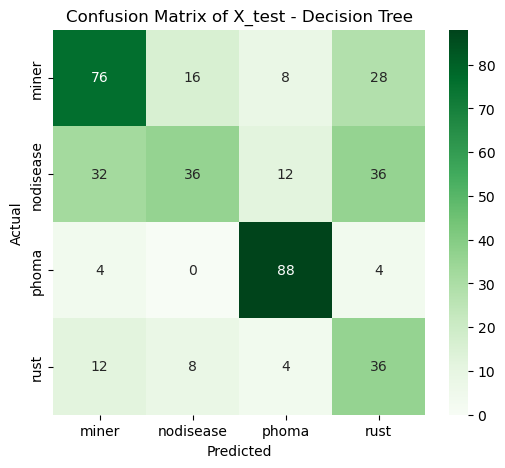

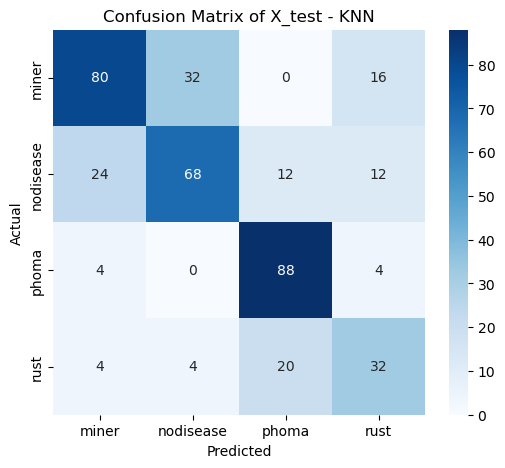

In [99]:
# Decision Tree
cm_test_dt = confusion_matrix(y_test, y_pred_dt)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_test_dt,
    annot=True,
    fmt='d',
    cmap='Greens',
    xticklabels=labels,
    yticklabels=labels
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of X_test - Decision Tree')

# KNN
cm_test_knn = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_test_knn,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=labels,
    yticklabels=labels
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of X_test - KNN')

## Find the Best Model

In [79]:
from sklearn.model_selection import GridSearchCV

# ---------- Decision Tree ----------
dt = DecisionTreeClassifier(max_features=None, random_state=123, splitter='best')
# multi_dt = MultiOutputClassifier(dt)
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': list(range(1, 21)) + [None],
    'min_samples_split': range(2, 11),
    'min_samples_leaf': range(1, 6)
}
grid_search_dt = GridSearchCV(dt, param_grid_dt, cv=10)
grid_search_dt.fit(X_train_scaled, y_train)

best_model_dt = grid_search_dt.best_estimator_
print(grid_search_dt.best_params_)
print(grid_search_dt.best_score_)

# ---------- KNN ----------
knn = KNeighborsClassifier(algorithm='auto', leaf_size=30, n_jobs=-1, p=2, weights='uniform')
# multi_knn = MultiOutputClassifier(knn)
param_grid_knn = {
    'metric': ['euclidean', 'manhattan'],
    'n_neighbors': range(1, 21),
}
grid_search_knn = GridSearchCV(knn, param_grid_knn, cv=10)
grid_search_knn.fit(X_train_scaled, y_train)

best_model_knn = grid_search_knn.best_estimator_
print(grid_search_knn.best_params_)
print(grid_search_knn.best_score_)

{'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2}
0.9891283245971657
{'metric': 'euclidean', 'n_neighbors': 1}
0.9891380314502038


### Predict X_valid

In [100]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

labels = ['nodisease', 'miner', 'rust', 'phoma']

# ---------- Decision Tree ----------
y_pred_valid_dt_best = best_model_dt.predict(X_valid_scaled)

print("\n=== Decision Tree Overall Metrics ===")
print(classification_report(y_valid, y_pred_valid_dt_best))
print("Accuracy (subset accuracy):", accuracy_score(y_valid, y_pred_valid_dt_best))
print("Precision (micro):", precision_score(y_valid, y_pred_valid_dt_best, average='micro', zero_division=0))
print("Recall (micro):", recall_score(y_valid, y_pred_valid_dt_best, average='micro', zero_division=0))
print("F1-score (micro):", f1_score(y_valid, y_pred_valid_dt_best, average='micro', zero_division=0))
print("Precision (macro):", precision_score(y_valid, y_pred_valid_dt_best, average='macro', zero_division=0))
print("Recall (macro):", recall_score(y_valid, y_pred_valid_dt_best, average='macro', zero_division=0))
print("F1-score (macro):", f1_score(y_valid, y_pred_valid_dt_best, average='macro', zero_division=0))

# ---------- KNN ----------
y_pred_valid_knn_best = best_model_knn.predict(X_valid_scaled)

print("\n=== KNN Overall Metrics ===")
print("Accuracy (subset accuracy):", accuracy_score(y_valid, y_pred_valid_knn_best))
print("Precision (micro):", precision_score(y_valid, y_pred_valid_knn_best, average='micro', zero_division=0))
print("Recall (micro):", recall_score(y_valid, y_pred_valid_knn_best, average='micro', zero_division=0))
print("F1-score (micro):", f1_score(y_valid, y_pred_valid_knn_best, average='micro', zero_division=0))
print("Precision (macro):", precision_score(y_valid, y_pred_valid_knn_best, average='macro', zero_division=0))
print("Recall (macro):", recall_score(y_valid, y_pred_valid_knn_best, average='macro', zero_division=0))
print("F1-score (macro):", f1_score(y_valid, y_pred_valid_knn_best, average='macro', zero_division=0))


=== Decision Tree Overall Metrics ===
              precision    recall  f1-score   support

       miner       0.79      0.82      0.81        66
   nodisease       0.81      0.91      0.86        57
       phoma       0.91      0.92      0.92        78
        rust       0.93      0.75      0.83        52

    accuracy                           0.86       253
   macro avg       0.86      0.85      0.85       253
weighted avg       0.86      0.86      0.86       253

Accuracy (subset accuracy): 0.857707509881423
Precision (micro): 0.857707509881423
Recall (micro): 0.857707509881423
F1-score (micro): 0.857707509881423
Precision (macro): 0.8616453701733857
Recall (macro): 0.8508848607532817
F1-score (macro): 0.8531147419392471

=== KNN Overall Metrics ===
Accuracy (subset accuracy): 0.9960474308300395
Precision (micro): 0.9960474308300395
Recall (micro): 0.9960474308300395
F1-score (micro): 0.9960474308300395
Precision (macro): 0.9962686567164178
Recall (macro): 0.9956140350877193
F1-s

Text(0.5, 1.0, 'Confusion Matrix of X_valid Using the Best Model - KNN')

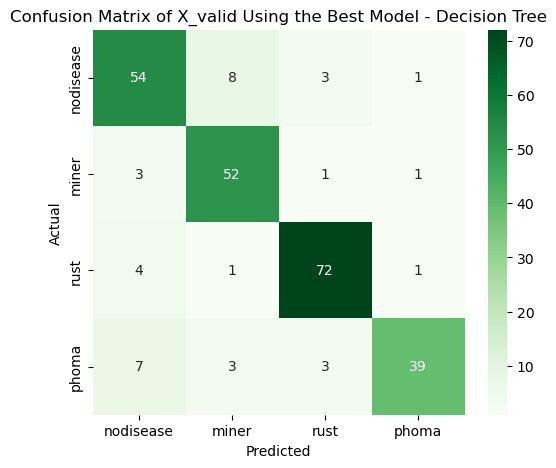

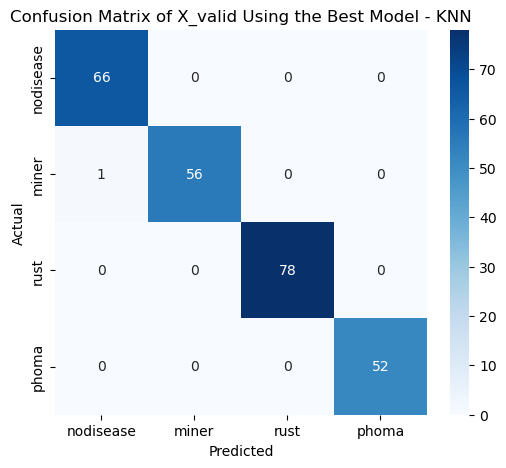

In [102]:
# Decision Tree
cm_valid_dt_best = confusion_matrix(y_valid, y_pred_valid_dt_best)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_valid_dt_best,
    annot=True,
    fmt='d',
    cmap='Greens',
    xticklabels=labels,
    yticklabels=labels
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of X_valid Using the Best Model - Decision Tree')

# KNN
cm_valid_knn_best = confusion_matrix(y_valid, y_pred_valid_knn_best)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_valid_knn_best,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=labels,
    yticklabels=labels
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of X_valid Using the Best Model - KNN')

### Predict X_test

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# ---------- Decision Tree ----------
y_pred_dt_best = best_model_dt.predict(X_test_scaled)

print("\n=== Decision Tree Overall Metrics ===")
print(classification_report(y_test, y_pred_dt_best))
print("Accuracy (subset accuracy):", accuracy_score(y_test, y_pred_dt_best))
print("Precision (micro):", precision_score(y_test, y_pred_dt_best, average='micro', zero_division=0))
print("Recall (micro):", recall_score(y_test, y_pred_dt_best, average='micro', zero_division=0))
print("F1-score (micro):", f1_score(y_test, y_pred_dt_best, average='micro', zero_division=0))
print("Precision (macro):", precision_score(y_test, y_pred_dt_best, average='macro', zero_division=0))
print("Recall (macro):", recall_score(y_test, y_pred_dt_best, average='macro', zero_division=0))
print("F1-score (macro):", f1_score(y_test, y_pred_dt_best, average='macro', zero_division=0))

# ---------- KNN ----------
y_pred_knn_best = best_model_knn.predict(X_test_scaled)

print("\n=== KNN Overall Metrics ===")
print("Accuracy (subset accuracy):", accuracy_score(y_test, y_pred_knn_best))
print("Precision (micro):", precision_score(y_test, y_pred_knn_best, average='micro', zero_division=0))
print("Recall (micro):", recall_score(y_test, y_pred_knn_best, average='micro', zero_division=0))
print("F1-score (micro):", f1_score(y_test, y_pred_knn_best, average='micro', zero_division=0))
print("Precision (macro):", precision_score(y_test, y_pred_knn_best, average='macro', zero_division=0))
print("Recall (macro):", recall_score(y_test, y_pred_knn_best, average='macro', zero_division=0))
print("F1-score (macro):", f1_score(y_test, y_pred_knn_best, average='macro', zero_division=0))


=== Decision Tree Overall Metrics ===
              precision    recall  f1-score   support

       miner       0.66      0.59      0.62       128
   nodisease       0.47      0.31      0.38       116
       phoma       0.71      0.92      0.80        96
        rust       0.48      0.67      0.56        60

    accuracy                           0.60       400
   macro avg       0.58      0.62      0.59       400
weighted avg       0.59      0.60      0.58       400

Accuracy (subset accuracy): 0.6
Precision (micro): 0.6
Recall (micro): 0.6
F1-score (micro): 0.6
Precision (macro): 0.5786811299661835
Recall (macro): 0.621857040229885
F1-score (macro): 0.5883765938069216

=== KNN Overall Metrics ===
Accuracy (subset accuracy): 0.65
Precision (micro): 0.65
Recall (micro): 0.65
F1-score (micro): 0.65
Precision (macro): 0.636612633509548
Recall (macro): 0.660326867816092
F1-score (macro): 0.6376623376623376


Text(0.5, 1.0, 'Confusion Matrix of X_test Using the Best Model - KNN')

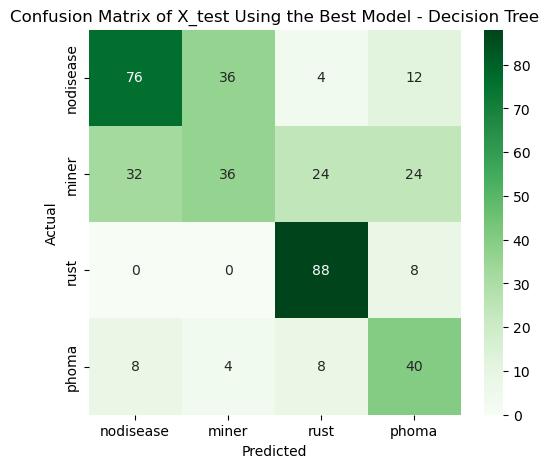

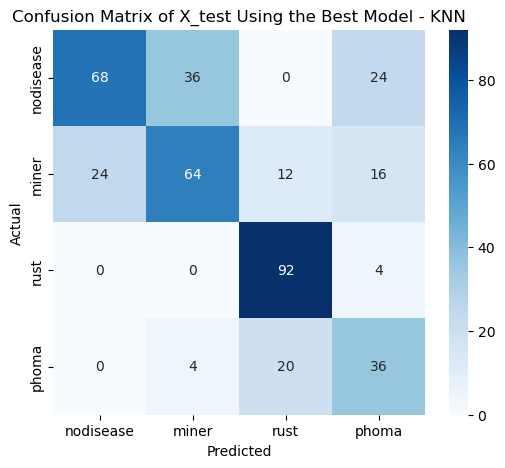

In [104]:
# Decision Tree
cm_test_dt_best = confusion_matrix(y_test, y_pred_dt_best)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_test_dt_best,
    annot=True,
    fmt='d',
    cmap='Greens',
    xticklabels=labels,
    yticklabels=labels  
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of X_test Using the Best Model - Decision Tree')

# KNN
cm_test_knn_best = confusion_matrix(y_test, y_pred_knn_best)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_test_knn_best,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=labels,
    yticklabels=labels
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of X_test Using the Best Model - KNN')